# Setup notebook

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from typing import Optional, Tuple, List, Dict
from numpy.typing import NDArray

from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

import sys
sys.path.append("../src/main/python")

from peak_analysis.helper_methods import (
    process_data,
    calculate_peak_aggregates,
    format_peak_data,
    format_agg_data,
    two_sample_t_test,
    plot_processing,
    plot_agg_output_comparison
)
from peak_analysis import (
    TraceProcessor,
    FirstNBaseLineFitter,
    SingleMaxPeakDetector,
    ModPolyCustomBaseLineFitter,
    NoiseSDScipyPeakDetector,
    RobustNoiseSDScipyPeakDetector,
)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", message="FigureCanvasAgg is non-interactive, and thus cannot be shown")

In [3]:

fp = mpl.font_manager.FontProperties(fname=r"C:\Users\tamas\AppData\Local\Microsoft\Windows\Fonts\Helvetica.ttf")
# fp = mpl.font_manager.FontProperties(fname=r"C:\Windows\Fonts\Arial.ttf")
print(fp.get_name())
# when installing a new non-system font the cache needs to be deleted
print(mpl.get_cachedir())

params = {
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Helvetica',
    'axes.labelsize': 'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
    'axes.linewidth': 2,
    'figure.dpi': 150
}
mpl.rcParams.update(params)

Helvetica
C:\Users\tamas\.matplotlib


In [4]:
DATA_PATH: str = "../data/DRGs"
OUTPUT_PATH: str = "./output/DRGs"

# Process data

## Treatment

## Controls

Processing ../data/DRGs/Mirus6/20230426_01.xlsx!
Processing ../data/DRGs/Mirus6/20230426_02.xlsx!
Processing ../data/DRGs/Mirus6/20230426_03.xlsx!
Processing ../data/DRGs/Mirus6/20230426_04.xlsx!
Processing ../data/DRGs/Mirus6/20230426_09.xlsx!
Processing ../data/DRGs/Mirus6+HC/20230426_06.xlsx!
Processing ../data/DRGs/Mirus6+HC/20230426_07.xlsx!
Processing ../data/DRGs/Mirus6+HC/20230426_08.xlsx!


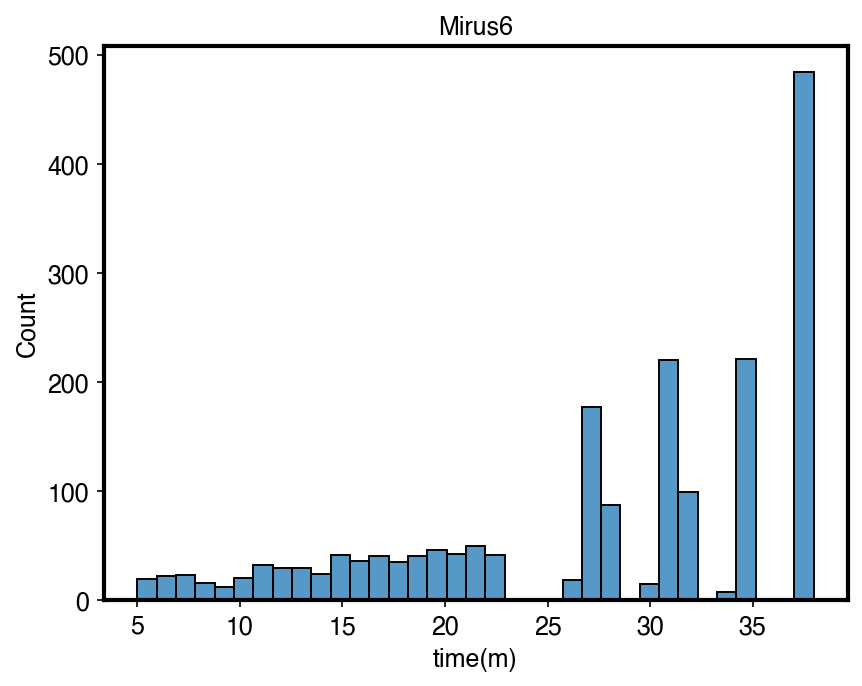

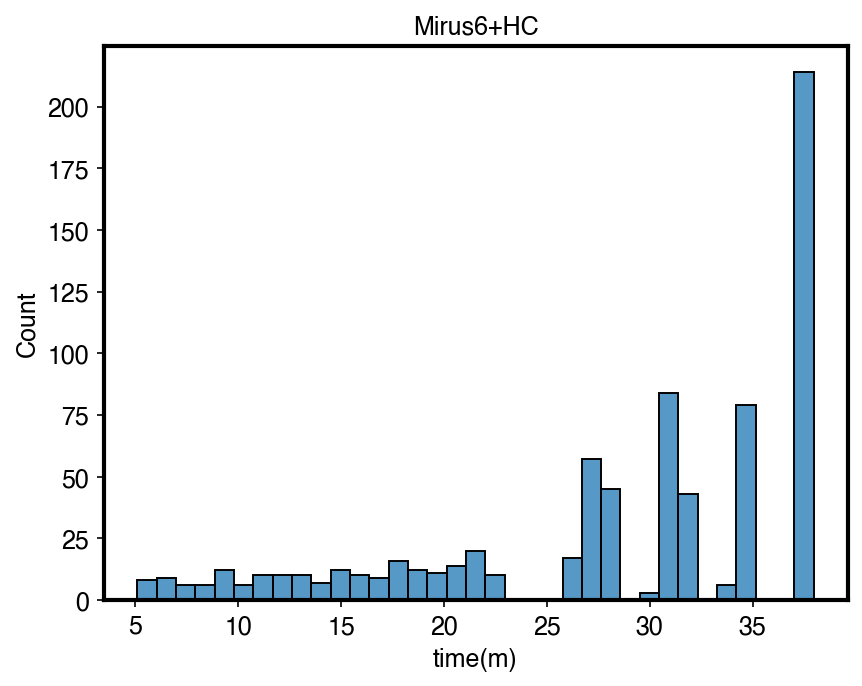

In [7]:
KEEP_PEAKLESS = False
FIRST_N = 15
all_segment_bounds = [
    (0.0, 22.76),
    (26.0, 28.0),
    (30.0, 32.0),
    (34.0, 35.0),
    (37.0, 38.0)
]
all_segment_names = ["Mirus", "PS", "AITC", "Capsaicin", "KCl"]
# we will save to a file for every condition
for condition_str in [
    "Mirus6",
    "Mirus6+HC"
]:
    # list for storing partial results over the loop
    _peaks_by_file: List[pd.DataFrame] = []
    _aggs_by_file: List[pd.DataFrame] = []
    # based on condition and experiment number find the folder and the files inside
    _relpath: str = f"{DATA_PATH}/{condition_str}"
    fname_list: List[str] = os.listdir(_relpath)
    # go over files
    for fname in fname_list:
        _path: str = f"{_relpath}/{fname}"
        print(f"Processing {_path}!")
        try:
            df_data = (
                pd.read_excel(_path, sheet_name='Sheet1')
                .rename({'Unnamed: 0': 'time(m)'}, axis=1)
                .interpolate(method='linear')
            )
        except ValueError:
            df_data = (
                pd.read_excel(_path, sheet_name=0)
                .rename({'Unnamed: 0': 'time(m)'}, axis=1)
                .interpolate(method='linear')
            )
        for segment_name, segment_bounds in zip(all_segment_names, all_segment_bounds):
            time_step: float = df_data["time(m)"].diff().max()
            if segment_name == "Mirus":
                _df_data_start = df_data[
                    (df_data['time(m)'] >= 1.5) & (df_data['time(m)'] <= 2)
                ].drop('time(m)', axis=1)
                stdev_base: pd.Series = _df_data_start.std(axis=0)
                df_segment_data = df_data[
                    df_data['time(m)'] <= segment_bounds[1]
                ]
                # true peaks cannot appear before 5 minutes!
                earliest_peak_idx: int = len(df_segment_data[df_segment_data['time(m)'] < 5.0])
                baseline_fitter = ModPolyCustomBaseLineFitter(
                    poly_order=2,
                    optional_segment_length=earliest_peak_idx
                )
                peak_detector = NoiseSDScipyPeakDetector(
                    prominence_in_stdev=20,
                    wlen=30,
                    distance=15,
                    min_peak_amplitude=(100.0, 100.0),
                    earliest_peak_idx=earliest_peak_idx,
                )
                _df_proc, _df_peaks = process_data(
                    df_input=df_segment_data,
                    time_colname='time(m)',
                    baseline_fitter=baseline_fitter,
                    peak_detector=peak_detector,
                    s_stdev=stdev_base
                )
            else:
                margin: float = time_step * FIRST_N
                df_segment_data = df_data[
                    (df_data['time(m)'] >= segment_bounds[0] - margin) & (df_data['time(m)'] <= segment_bounds[1])
                ].copy()
                # true peaks cannot appear before the segment start!
                earliest_peak_idx: int = len(df_segment_data[df_segment_data['time(m)'] < segment_bounds[0]])
                baseline_fitter = FirstNBaseLineFitter(
                    agg_func=np.mean,
                    first_n=FIRST_N
                )
                peak_detector = SingleMaxPeakDetector(
                    min_peak_amplitude=(100.0, 100.0),
                    earliest_peak_idx=earliest_peak_idx,
                )
                _df_proc, _df_peaks = process_data(
                    df_input=df_segment_data,
                    time_colname='time(m)',
                    baseline_fitter=baseline_fitter,
                    peak_detector=peak_detector,
                )
            if KEEP_PEAKLESS:
                # We will fill in zeros for cells which didnt have a peak
                _all_cells = pd.DataFrame({"cell_nr": [x for x in df_segment_data.columns if x != 'time(m)']})
                _df_peaks = _all_cells.merge(_df_peaks, how='outer', on="cell_nr").fillna({'amplitude':0})
                
            # extract the experiment date and number from the filename
            file_str: str = fname.replace(".xlsx", "")
            _df_agg: pd.DataFrame = calculate_peak_aggregates(_df_peaks)
            _df_agg["segment_name"] = segment_name
            _df_peaks = format_peak_data(
                df_peaks=_df_peaks,
                condition_str=f"{condition_str}",
                file_str=file_str,
            )
            _df_peaks["segment_name"] = segment_name
            _peaks_by_file.append(
                _df_peaks
            )
            _aggs_by_file.append(
                format_agg_data(
                    df_agg=_df_agg,
                    condition_str=f"{condition_str}",
                    file_str=file_str
                )
            )

    # merge results from the separate files
    peak_output: pd.DataFrame = pd.concat(_peaks_by_file, ignore_index=True)
    agg_output: pd.DataFrame = pd.concat(_aggs_by_file, ignore_index=True)
    # add new peak_nr column in the first position, index it starting at 1, ignoring  dummy 0 peaks
    peak_output.dropna(axis=0, inplace=True)
    peak_output.insert(loc=0, column='peak_nr', value=peak_output.index + 1)
    # add new cell_nr column in the first position, index it starting at 1
    # agg_output.insert(loc=0, column='cell_nr', value=agg_output.index + 1)
    # save to file
    peak_output.to_excel(f"{OUTPUT_PATH}/peak_analysis_{condition_str}.xlsx", index=False)
    agg_output.to_excel(f"{OUTPUT_PATH}/cell_analysis_{condition_str}.xlsx", index=False)
    # save histogram
    fig, ax = plt.subplots()
    sns.histplot(peak_output, x="time(m)", bins=35, ax=ax).get_figure()
    ax.set_title(condition_str)
    fig.savefig(f"{OUTPUT_PATH}/time_histogram_{condition_str}.jpg")

## Comparison

## Mirus

c:\Users\tamas\.conda\envs\peak_analysis\lib\site-packages\statsmodels\stats\weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


   condition  % Responders
0     Mirus6         100.0
1  Mirus6+HC         100.0
Saving plot to: ././output/DRGs/response_rate_peak_count.png
   condition  Mean nr. of peaks
0     Mirus6           1.925806
1  Mirus6+HC           2.062500
Saving plot to: ././output/DRGs/mean_peak_count.png
   condition  Mean amplitude (µM)
0     Mirus6             0.381774
1  Mirus6+HC             0.490114
Saving plot to: ././output/DRGs/mean_mean_peak_amplitude.png
   condition  Mean max. amplitude (µM)
0     Mirus6                  0.498652
1  Mirus6+HC                  0.675822
Saving plot to: ././output/DRGs/mean_max_peak_amplitude.png


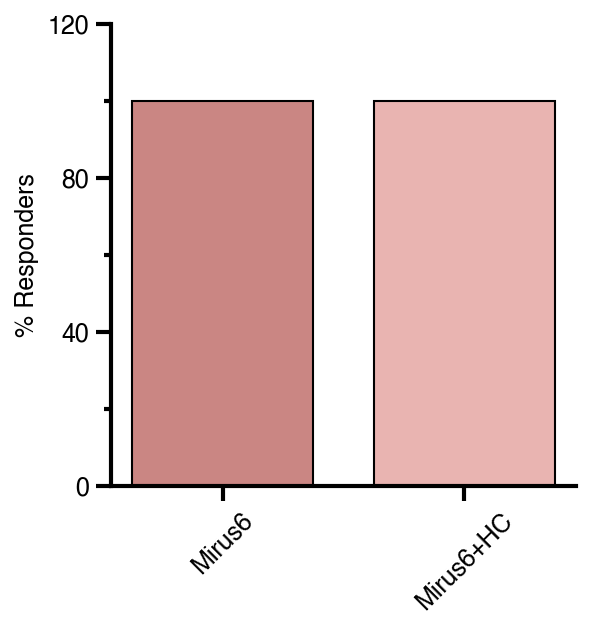

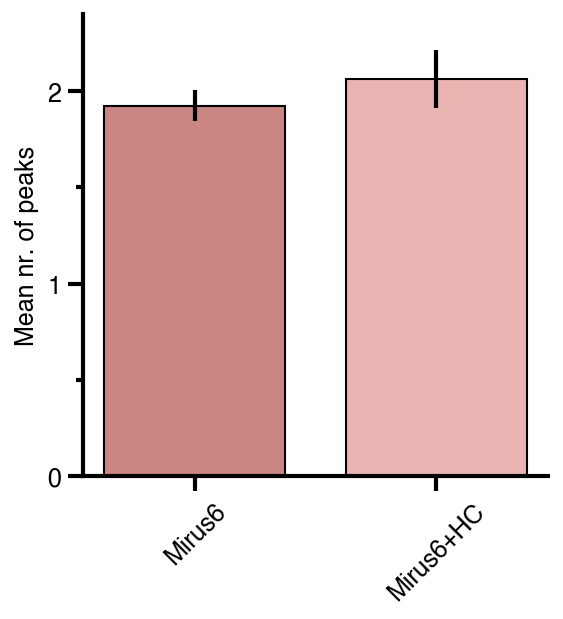

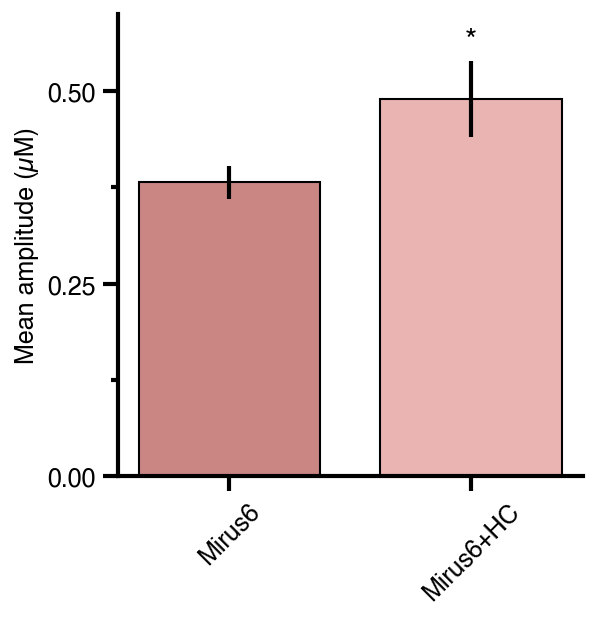

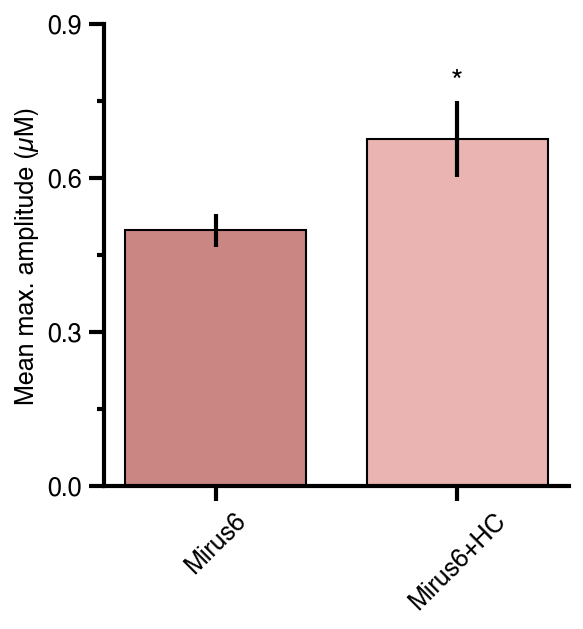

In [9]:
agg_outputs: List[pd.DataFrame] = []
for condition in [
    "Mirus6",
    "Mirus6+HC"
]:
    agg_output = pd.read_excel(f"./{OUTPUT_PATH}/cell_analysis_{condition}.xlsx")
    # Only look at the Mirus segments
    agg_output = agg_output[agg_output["segment_name"] == "Mirus"]
    # scale down the y values by a factor of 1000
    for c in agg_output.columns:
        if "amplitude" in c:
            agg_output[c] = agg_output[c] / 1000.0
    agg_outputs.append(agg_output)

comparisons = {
    "peak_count": ["response_rate", "mean"],
    "mean_peak_amplitude": ["mean"],
    "max_peak_amplitude": ["mean" ] 
}

plot_agg_output_comparison(
    agg_outputs=agg_outputs,
    comparisons=comparisons,
    n_major_ticks=3,
    n_minor_to_major=2,
    figsize=(4, 4),
    colors=("#D67B77", "#F2ABA8"),
    alpha=1.0,
    x_rotation=45,
    width=0.75,
    condition_alias_dict={
        "nothing": "no appl.",
        "Mirus6wt": "Mirus6 WT"
    },
    colname_alias_dict={
        "mean_peak_amplitude": "amplitude (µM)",
        "peak_count": "nr. of peaks",
        "max_peak_amplitude": "max. amplitude (µM)",
    },
    errorbar_type="se",
    savepath=f"./{OUTPUT_PATH}"
)

## Mirus + Controls

In [71]:
agg_output

cell_nr  peak_count  first_peak_time  mean_peak_amplitude  \
0           1           2          17.1026           299.524681   
1           2           0              NaN             0.000000   
2           3           0              NaN             0.000000   
3           4           0              NaN             0.000000   
4           5           1          20.3359          1108.884113   
...       ...         ...              ...                  ...   
3365      120           1          37.5026          1681.370600   
3366      121           1          37.5026          1955.944733   
3367      122           1          37.5359          2103.882467   
3368      123           1          37.5359           850.986467   
3369      124           1          37.6692          1129.973600   

      max_peak_amplitude  max_peak_time segment_name                 cell_ID  
0             458.608093        17.1026        Mirus    Mirus6_20230426_01_1  
1               0.000000            NaN        Mirus    Mirus6_20230426_01_2  
2               0.000000            NaN        Mirus    Mirus6_20230426_01_3  
3               0.000000            NaN        Mirus    Mirus6_20230426_01_4  
4            1108.884113        20.3359        Mirus    Mirus6_20230426_01_5  
...                  ...            ...          ...                     ...  
3365         1681.370600        37.5026          KCl  Mirus6_20230426_09_120  
3366         1955.944733        37.5026          KCl  Mirus6_20230426_09_121  
3367         2103.882467        37.5359          KCl  Mirus6_20230426_09_122  
3368          850.986467        37.5359          KCl  Mirus6_20230426_09_123  
3369         1129.973600        37.6692          KCl  Mirus6_20230426_09_124  

[3370 rows x 8 columns]

In [105]:
condition_str = "Mirus6"
agg_output = pd.read_excel(f"{OUTPUT_PATH}/cell_analysis_{condition_str}.xlsx")

test = agg_output.copy()
test["responded_IC"] = (test["peak_count"] > 0).astype(int)
test: pd.DataFrame = test.pivot(
    index="cell_ID", columns="segment_name", values="responded_IC"
)
test.columns.name = None
test = (
    test.groupby(["AITC", "Capsaicin", "PS"])[["Mirus"]].agg(
        lambda x: x.sum() / x.count() * 100
    )
)
test.columns = ["% responded to Mirus"]
print(test)
print("--------------------------------------")
test = agg_output.copy()
test["responded_IC"] = (test["peak_count"] > 0).astype(int)
test: pd.DataFrame = test.pivot(
    index="cell_ID", columns="segment_name", values="responded_IC"
)
test.columns.name = None
test = (
    test.groupby(["AITC", "Capsaicin", "PS"])[["Mirus"]].agg(
        lambda x: x.sum()
    )
)
test["Mirus"] = test["Mirus"] / test["Mirus"].sum() * 100
test.columns = ["% of Mirus responders"]
print(test)

# test = agg_output.copy()
# test["responded_IC"] = (test["peak_count"] > 0).astype(int)
# test: pd.DataFrame = test.pivot(
#     index="cell_ID", columns="segment_name", values="responded_IC"
# )
# test.columns.name = None
# test = (
#     test.groupby(["Mirus"])[["AITC", "Capsaicin", "PS"]].agg(
#         lambda x: x.sum()
#     )
# )
# test[""]
# test.columns = ["% resp. to Mirus"]
# print(test)

                   % responded to Mirus
AITC Capsaicin PS                      
0    0         0              44.247788
               1              49.090909
     1         0              50.000000
               1              56.000000
1    0         0              45.161290
               1              47.222222
     1         0              58.974359
               1              40.769231
--------------------------------------
                   % of Mirus responders
AITC Capsaicin PS                       
0    0         0               32.258065
               1                8.709677
     1         0                5.483871
               1                4.516129
1    0         0               13.548387
               1               10.967742
     1         0                7.419355
               1               17.096774


In [104]:
condition_str = "Mirus6"
agg_output = pd.read_excel(f"{OUTPUT_PATH}/cell_analysis_{condition_str}.xlsx")

data = agg_output.copy()
data["responded_IC"] = (data["peak_count"] > 0).astype(int)
data: pd.DataFrame = data.pivot(
    index="cell_ID", columns="segment_name", values="responded_IC"
)
data.columns.name = None
# X = data[["AITC", "Capsaicin", "PS"]]
# X = sm.add_constant(X)
# y = data["Mirus"]
# model = sm.Logit(y, X)
model = smf.logit("Mirus~1+AITC*Capsaicin*PS", data=data)
result = model.fit()
print(result.summary())
print("\n")
print(np.exp(result.params))
print("---------------------")
print(np.exp(result.params[0])/(1 + np.exp(result.params[0])))

Optimization terminated successfully.
         Current function value: 0.685587
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                  Mirus   No. Observations:                  674
Model:                          Logit   Df Residuals:                      666
Method:                           MLE   Df Model:                            7
Date:                Sun, 17 Dec 2023   Pseudo R-squ.:                0.006301
Time:                        20:49:46   Log-Likelihood:                -462.09
converged:                       True   LL-Null:                       -465.02
Covariance Type:            nonrobust   LLR p-value:                    0.5562
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.2311      0.134     -1.726      0.084      -0.494       0.031
AITC    

In [58]:
agg_output[
    (agg_output["cell_ID"].str.startswith("Mirus6+HC"))
    & (agg_output["cell_ID"].str.endswith("08_64"))
]

cell_nr  peak_count  first_peak_time  mean_peak_amplitude  \
733        64           6          13.6692          1219.825847   
814        64           0              NaN             0.000000   
895        64           0              NaN             0.000000   
976        64           0              NaN             0.000000   
1057       64           1          37.5359          2244.050000   

      max_peak_amplitude  max_peak_time segment_name                   cell_ID  
733          4067.674833        18.4026        Mirus  Mirus6+HC_20230426_08_64  
814             0.000000            NaN           PS  Mirus6+HC_20230426_08_64  
895             0.000000            NaN         AITC  Mirus6+HC_20230426_08_64  
976             0.000000            NaN    Capsaicin  Mirus6+HC_20230426_08_64  
1057         2244.050000        37.5359          KCl  Mirus6+HC_20230426_08_64

# Test

In [18]:
FIRST_N = 15
mirus6_example = f'{DATA_PATH}/Mirus6/20230426_03.xlsx'
mirus6hc_example = f'{DATA_PATH}/Mirus6+HC/20230426_06.xlsx'
df_data = (
    pd.read_excel(mirus6_example, sheet_name='Sheet1')
    .rename({'Unnamed: 0': 'time(m)'}, axis=1)
    .interpolate(method='linear')
)

time_step: float = df_data["time(m)"].diff().max()
margin: float = time_step * FIRST_N
df_data = df_data[
    # (df_data['time(m)'] >= 26.0 - margin) & (df_data['time(m)'] <= 28.0)
    df_data['time(m)'] <= 22.76
]
_df_data_start = df_data[
    (df_data['time(m)'] >= 1.5) & (df_data['time(m)'] <= 2)
].drop('time(m)', axis=1)
stdev_base: pd.Series = _df_data_start.std(axis=0)

c:\python_projects\peak_analysis\peak_analysis\notebooks\../src/main/python\peak_analysis\helper_methods.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(10, 3))


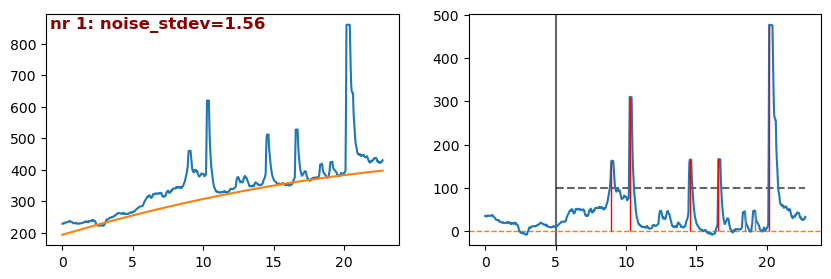

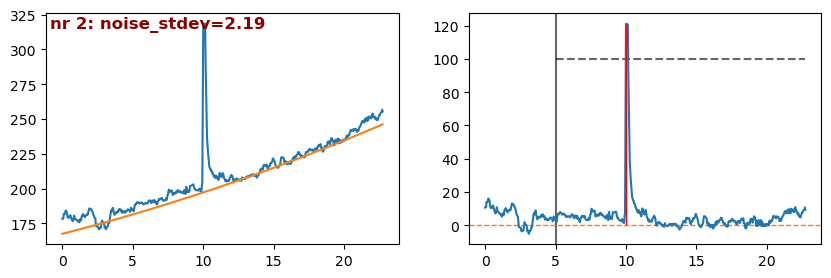

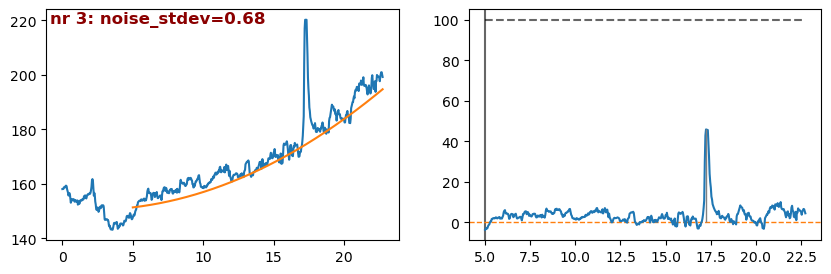

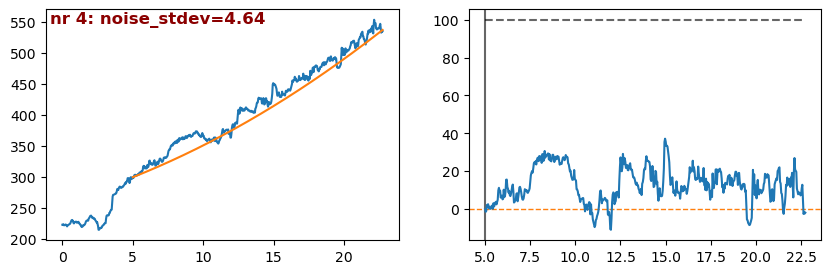

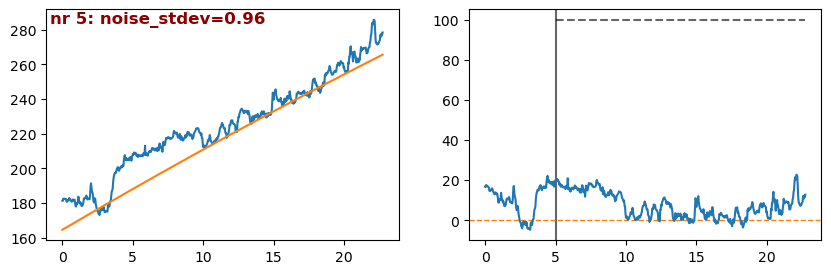

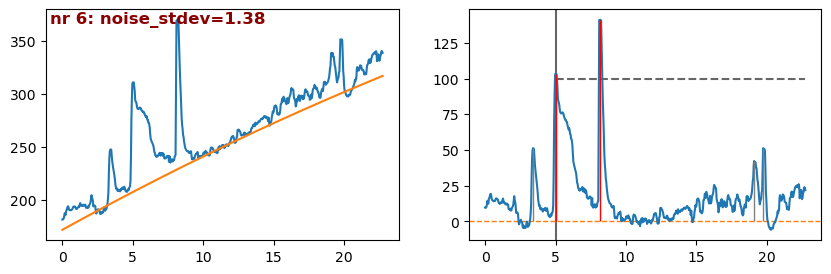

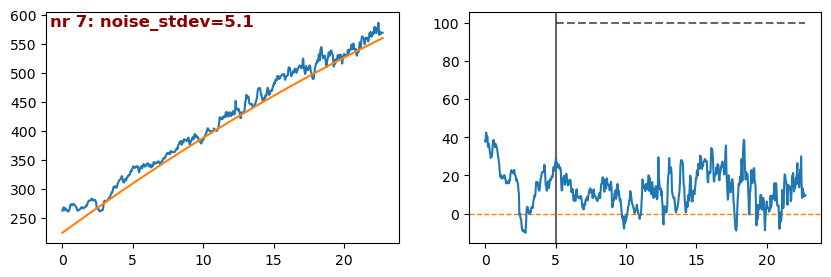

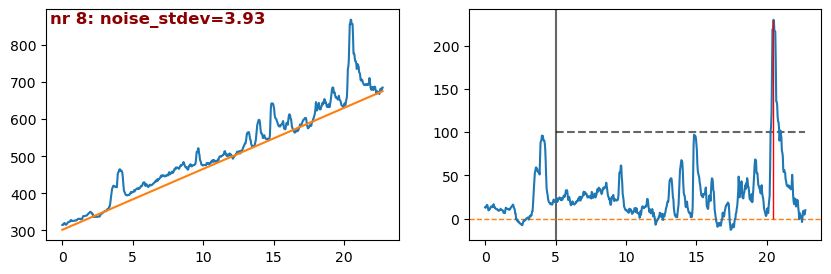

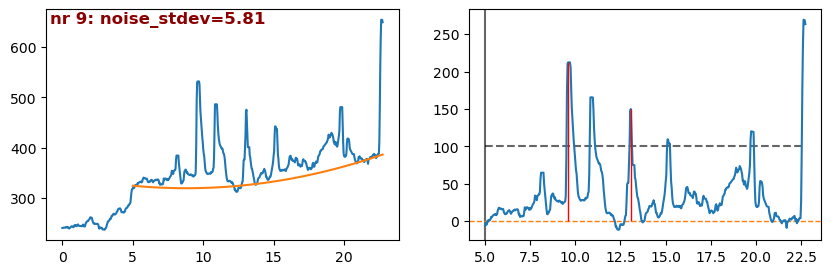

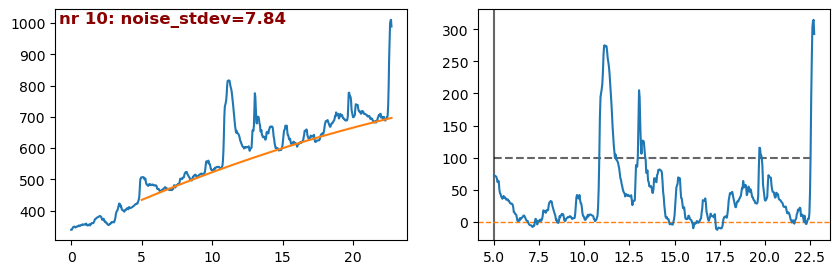

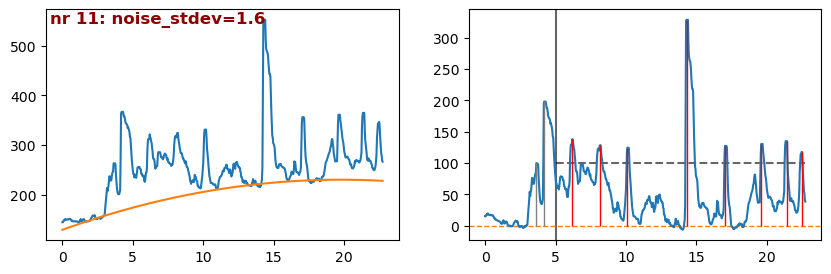

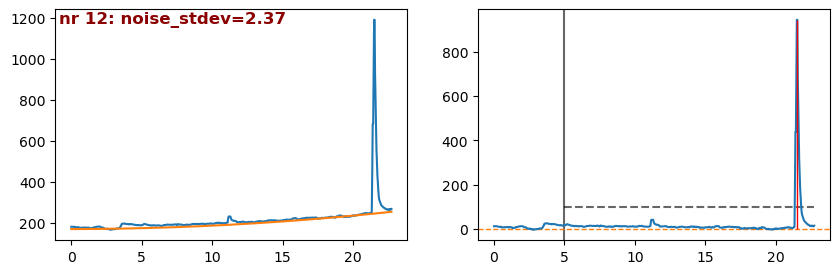

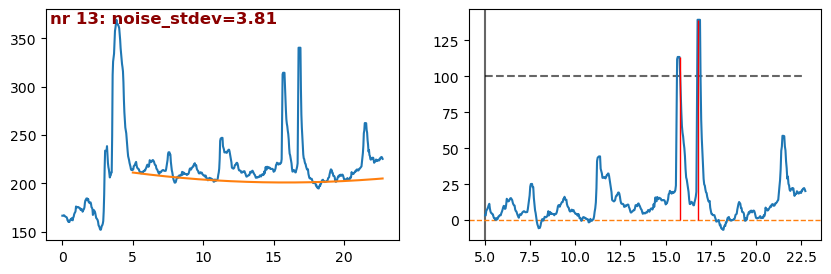

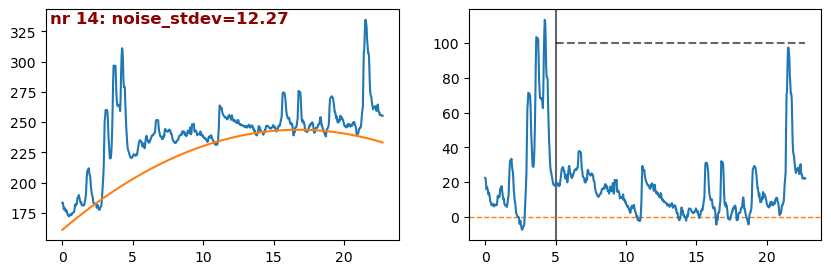

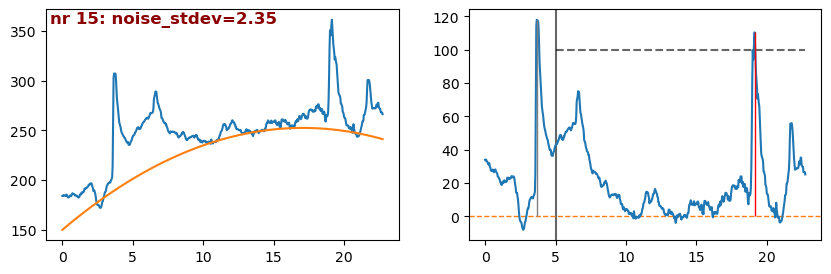

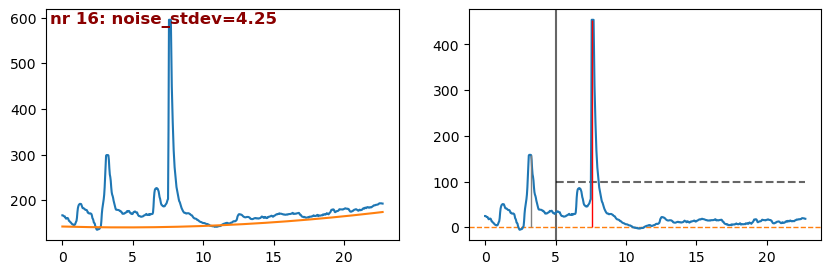

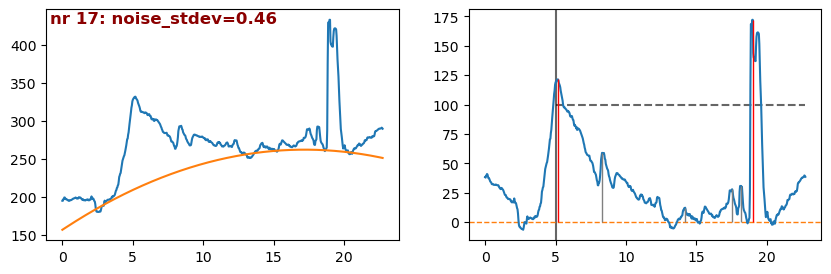

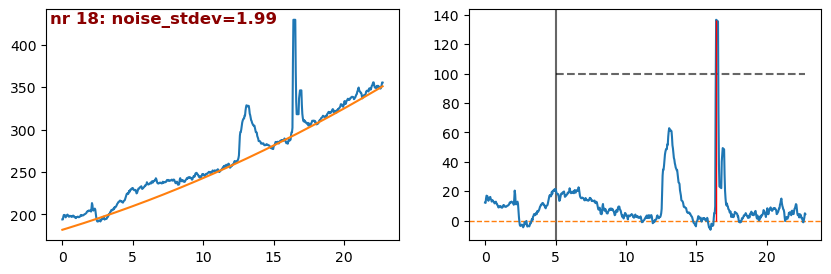

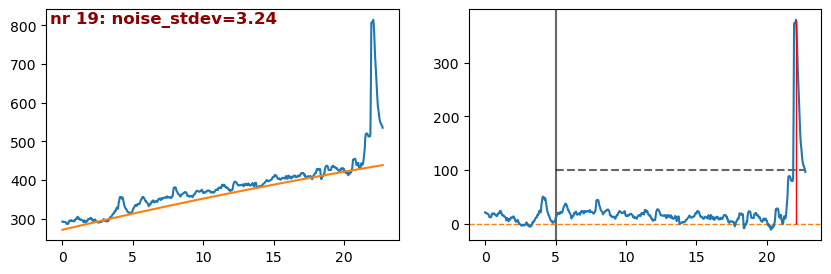

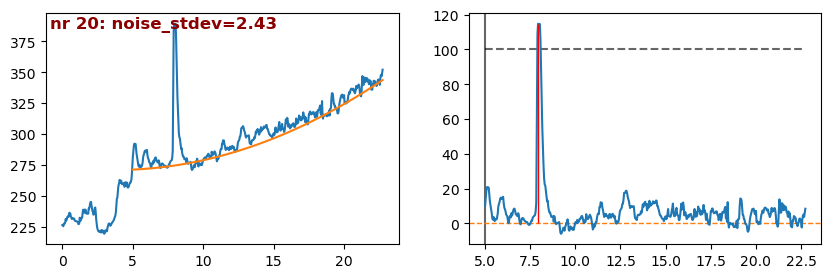

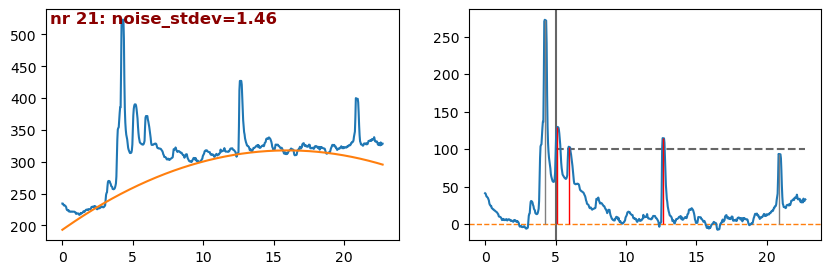

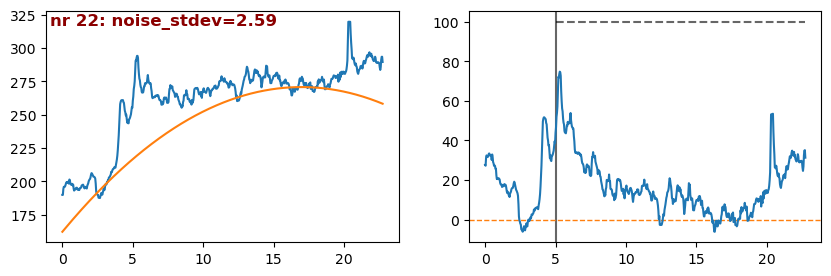

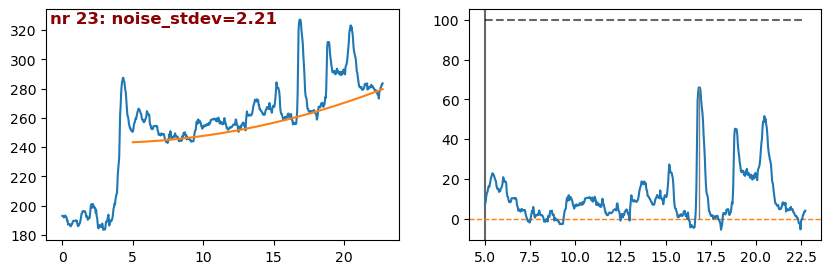

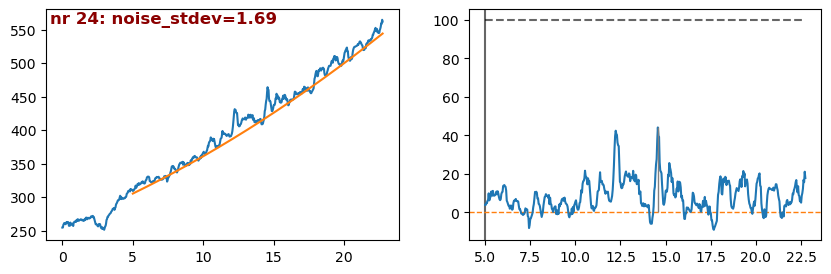

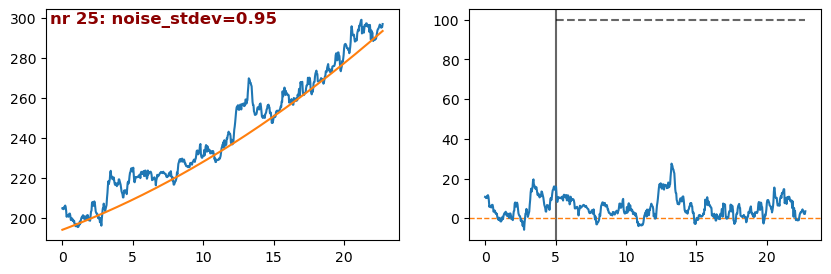

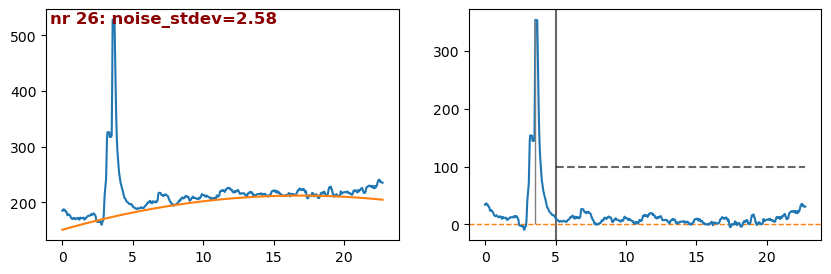

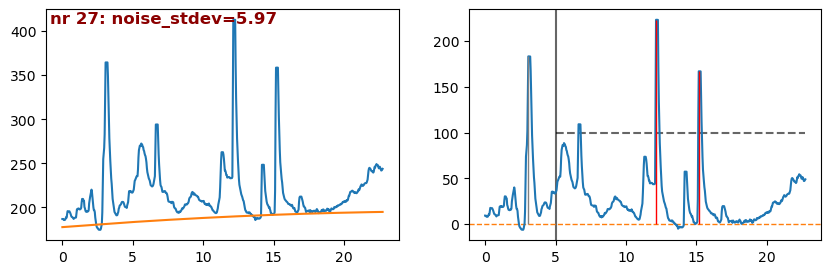

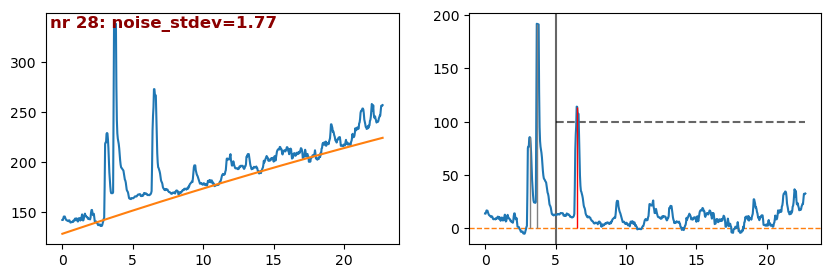

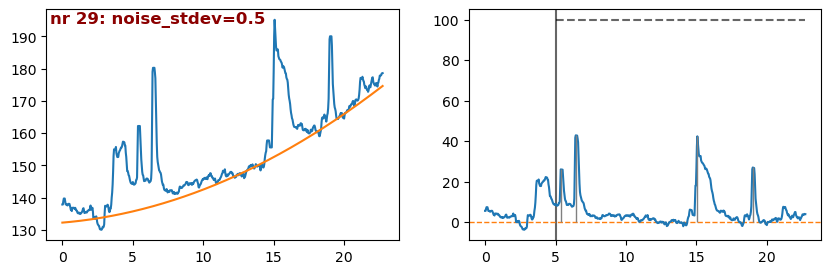

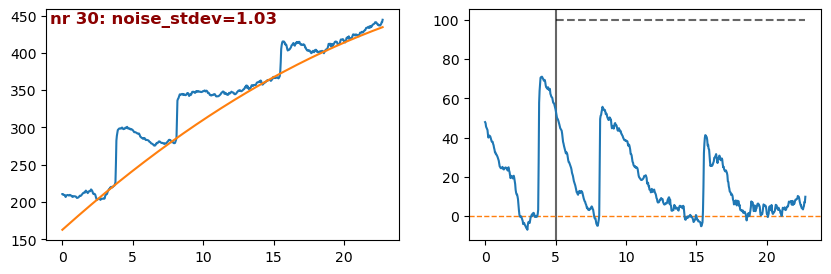

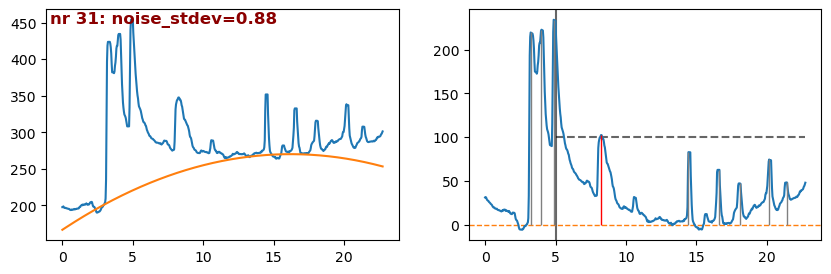

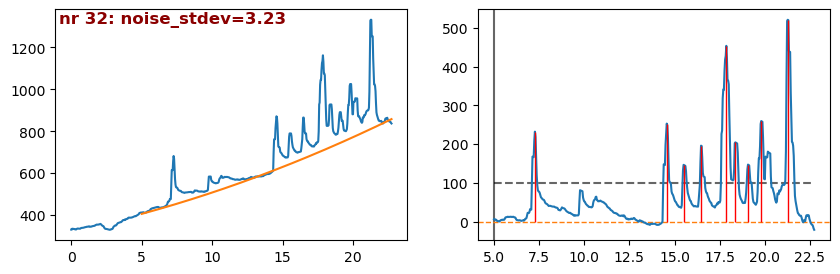

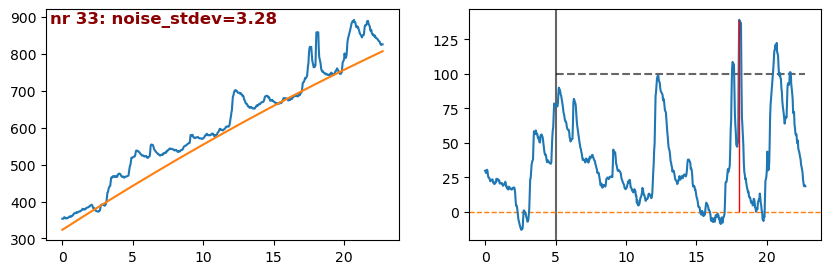

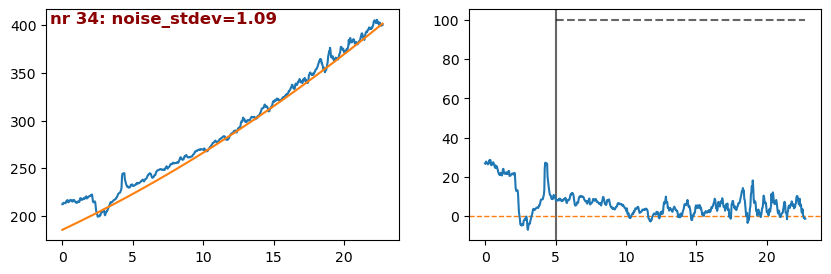

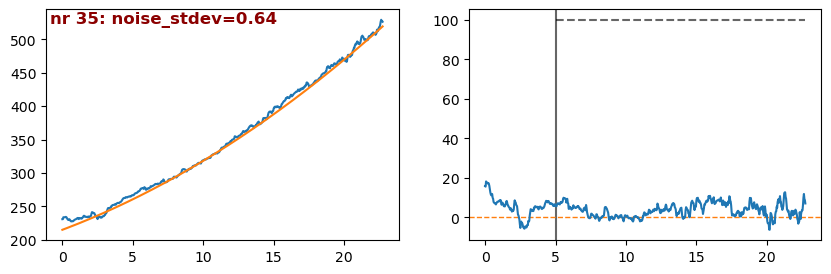

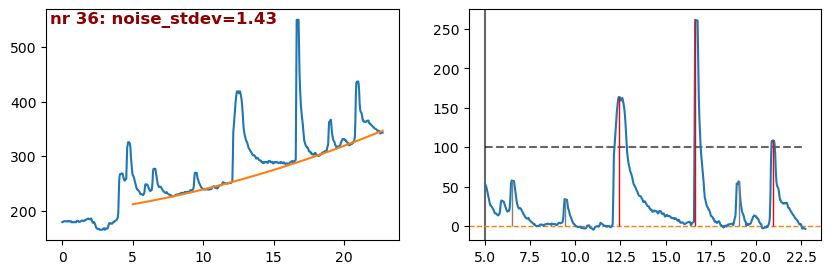

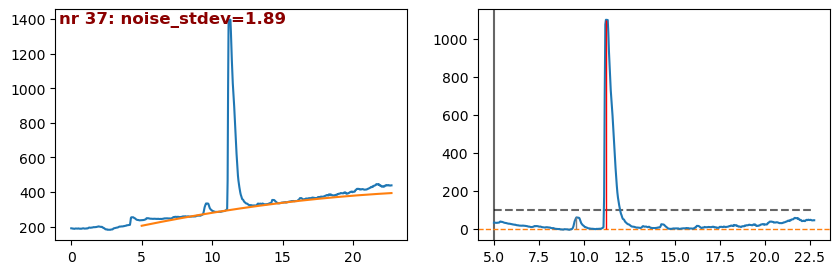

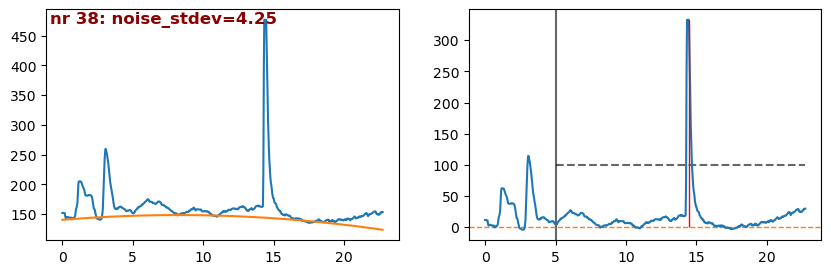

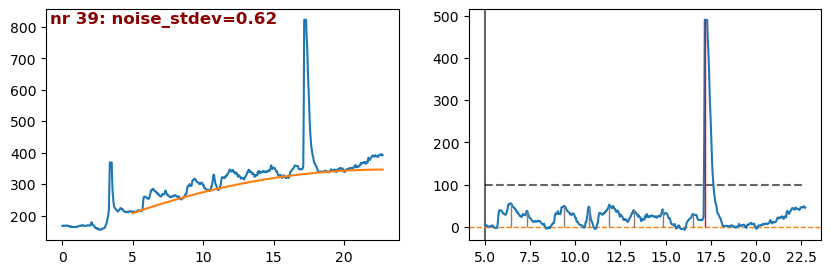

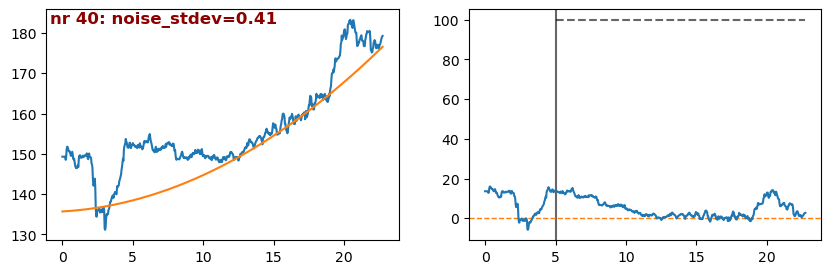

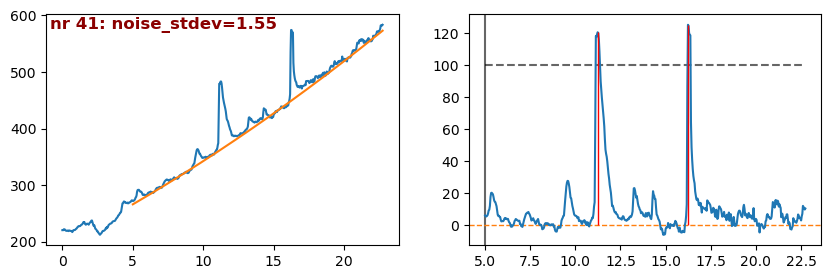

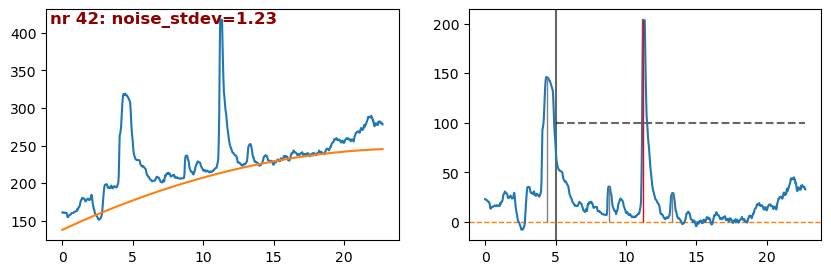

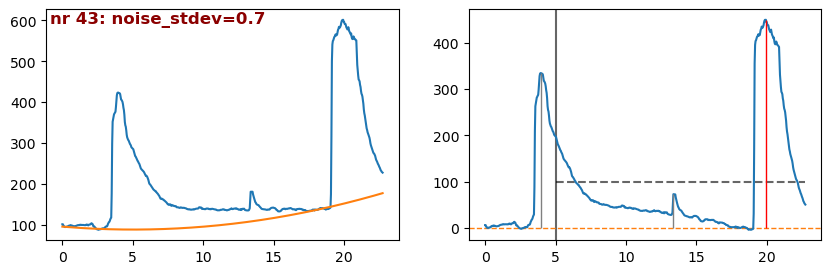

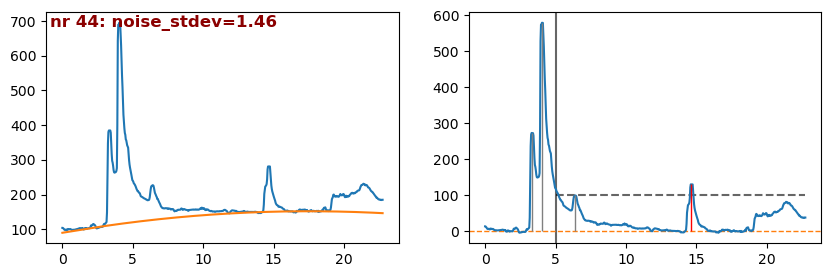

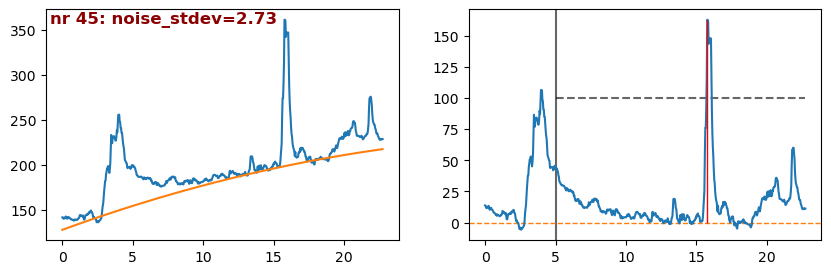

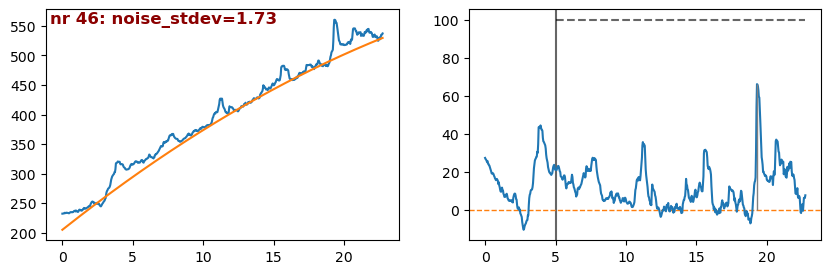

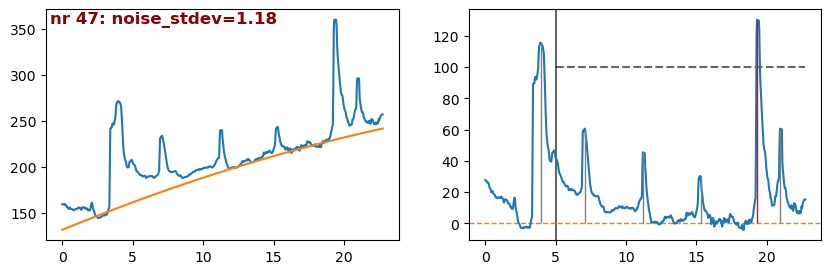

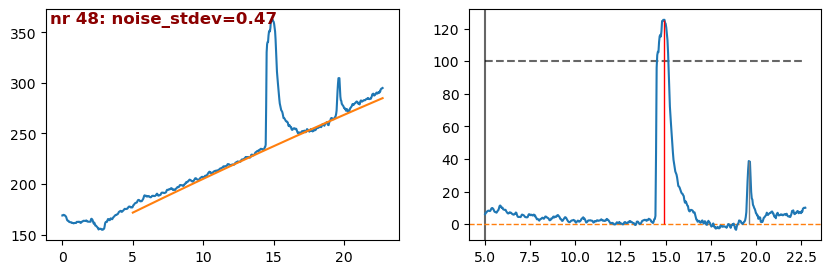

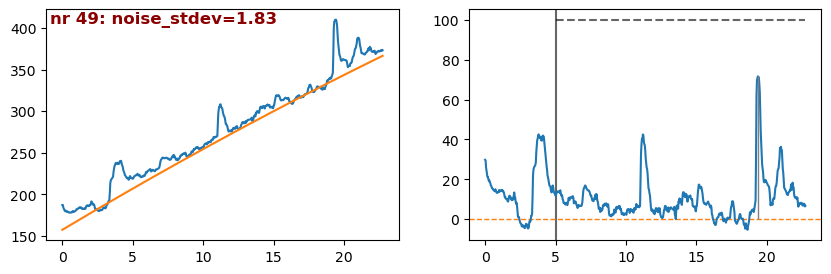

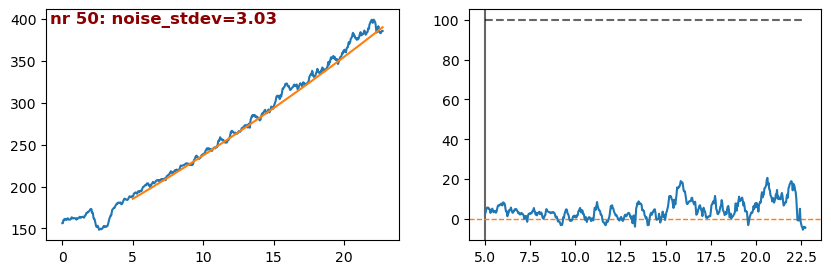

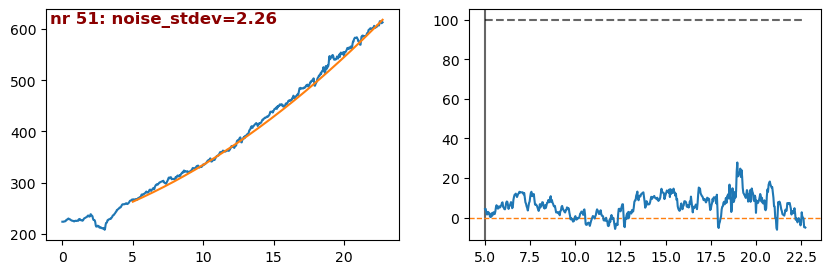

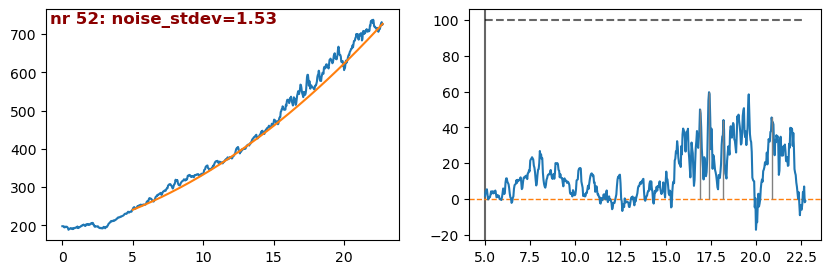

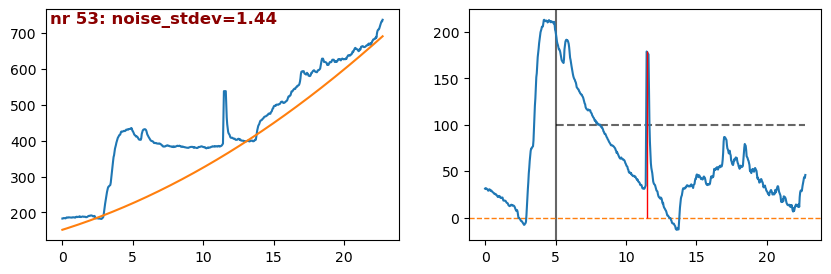

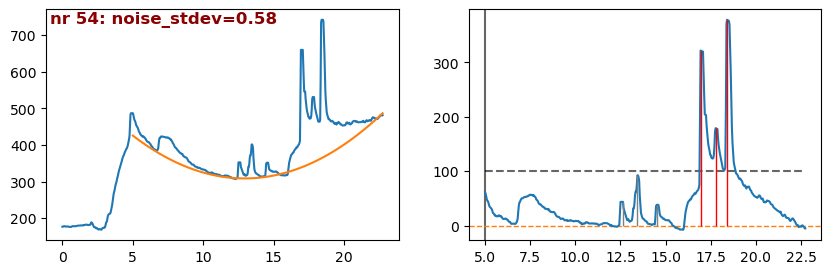

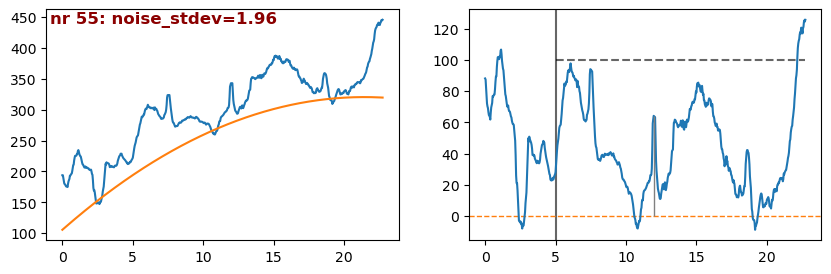

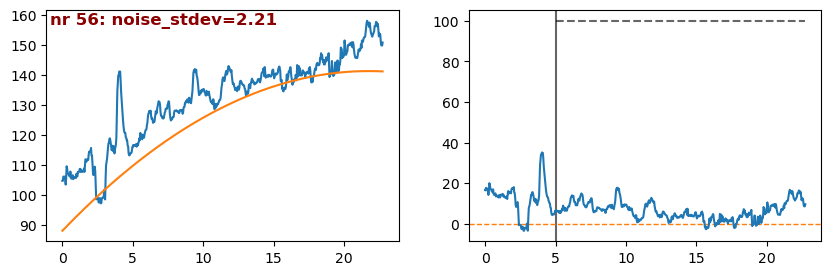

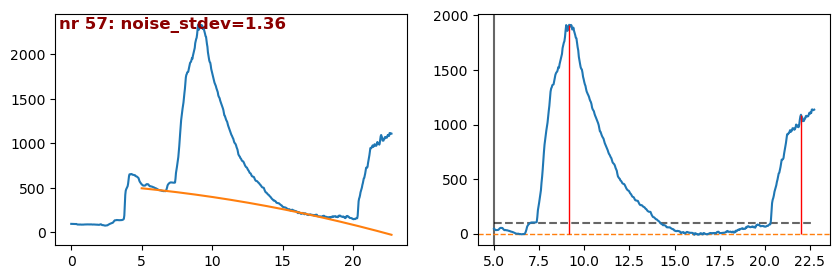

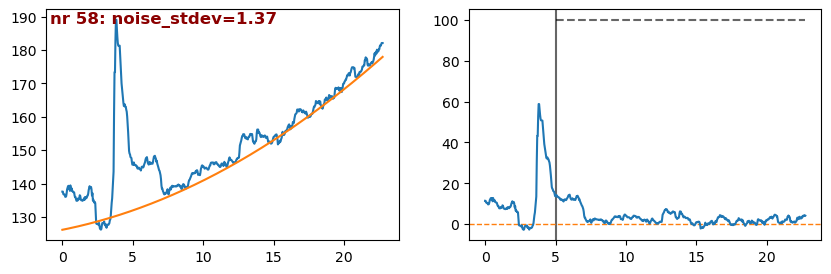

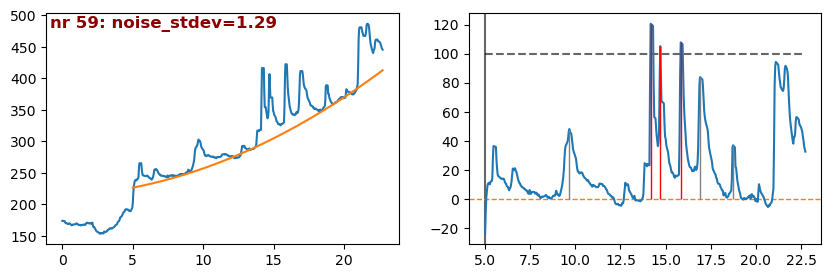

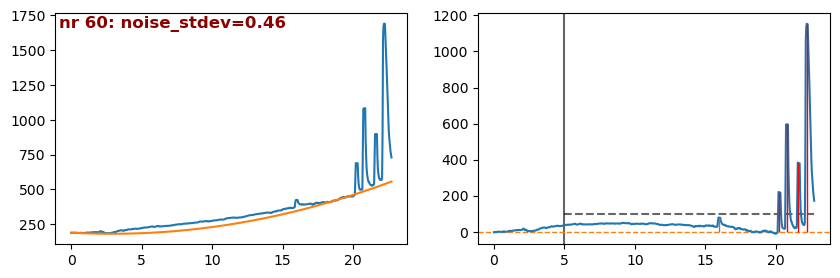

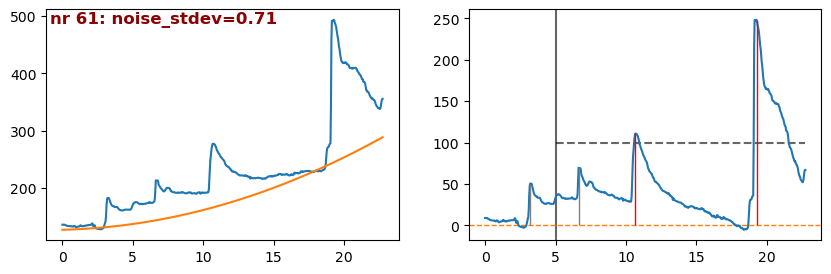

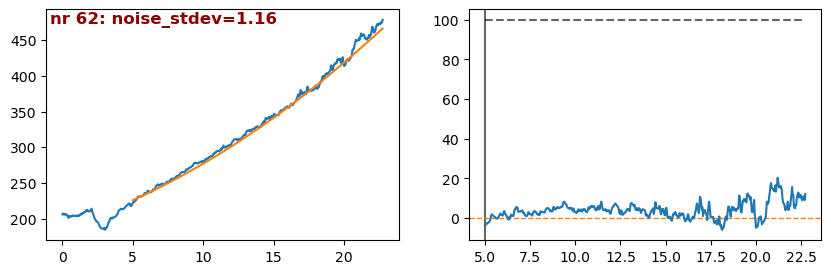

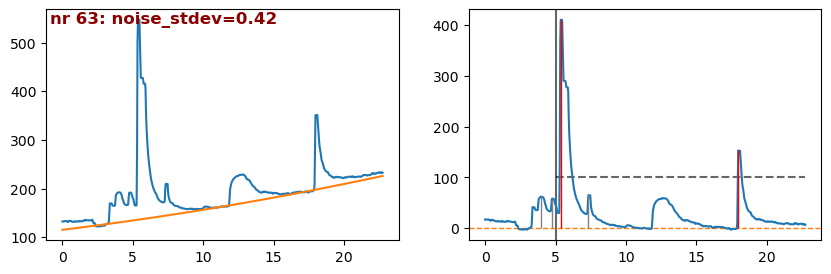

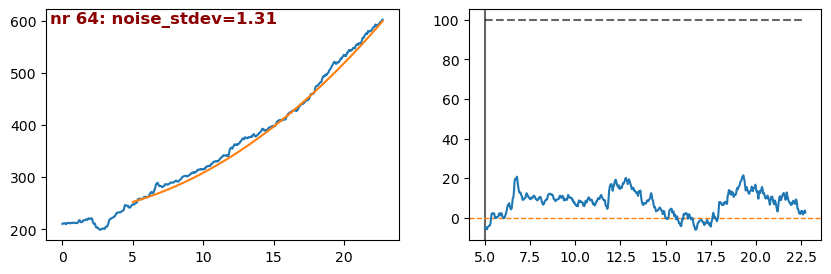

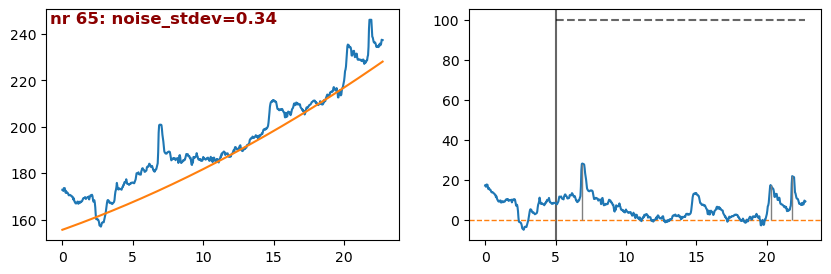

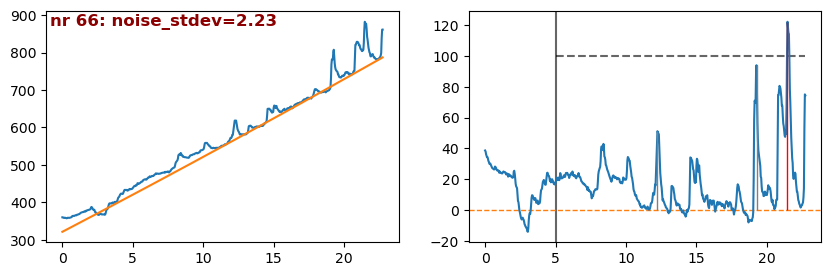

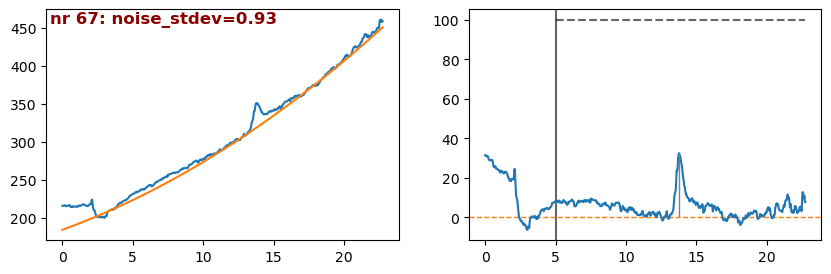

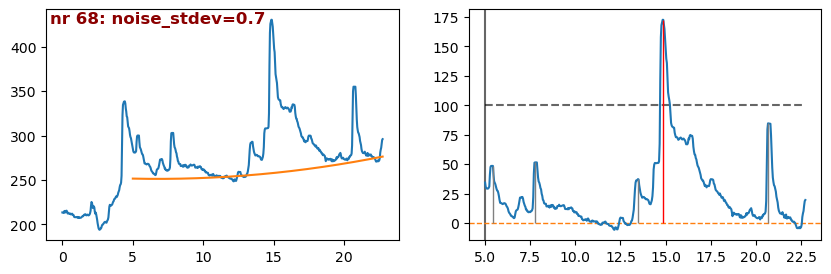

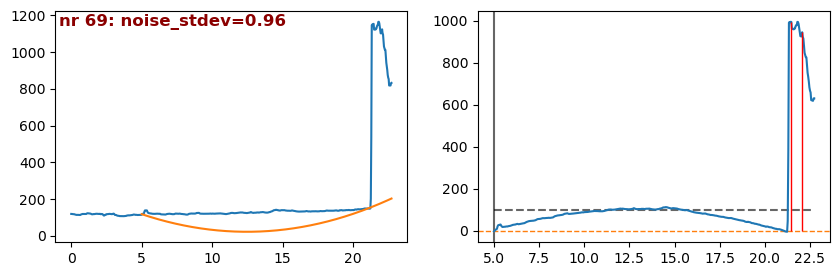

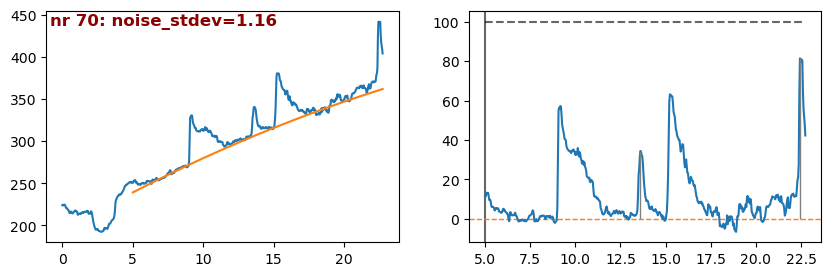

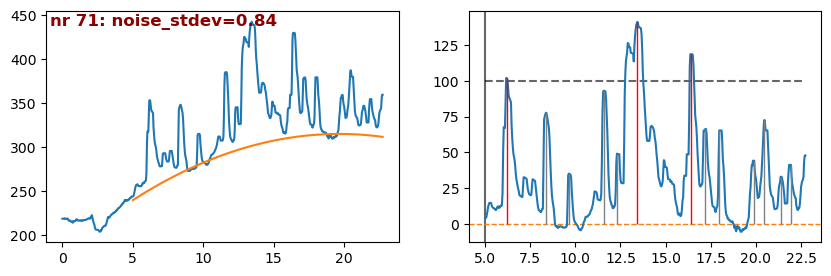

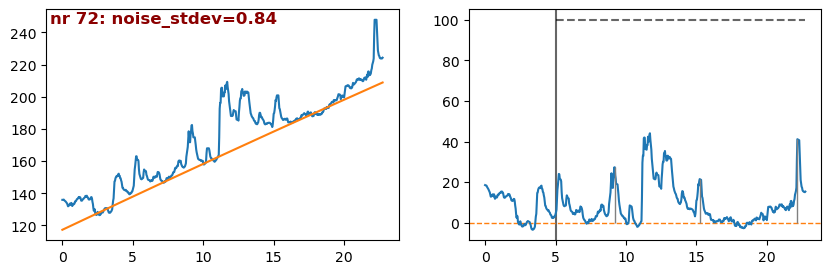

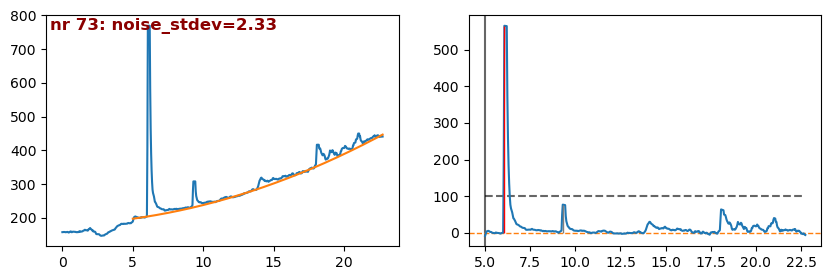

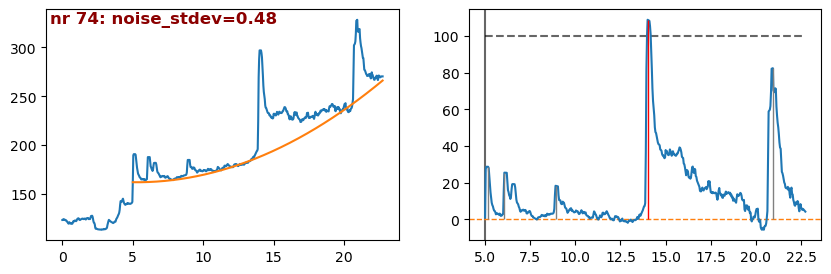

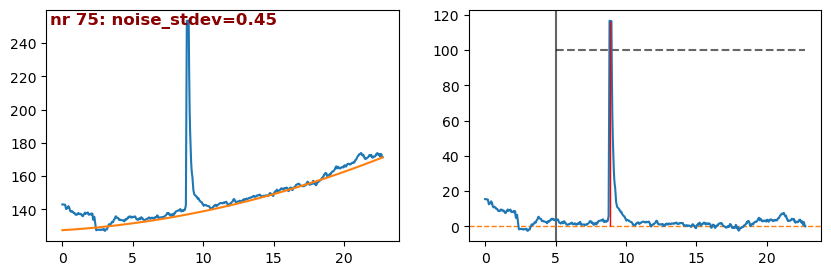

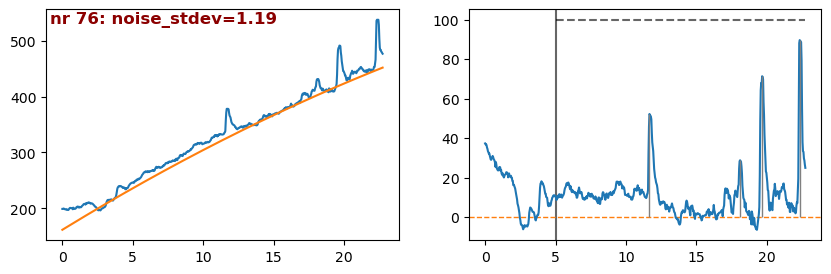

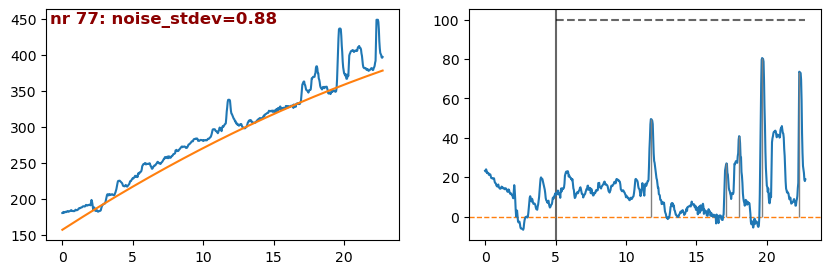

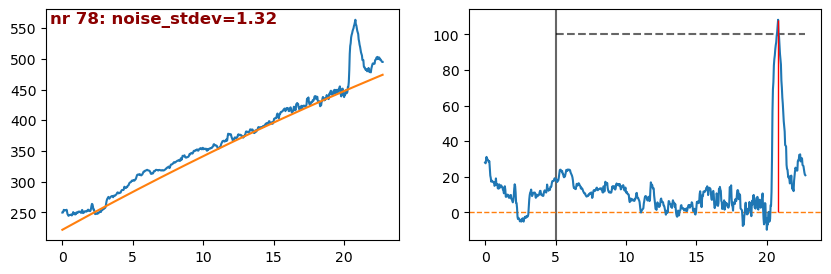

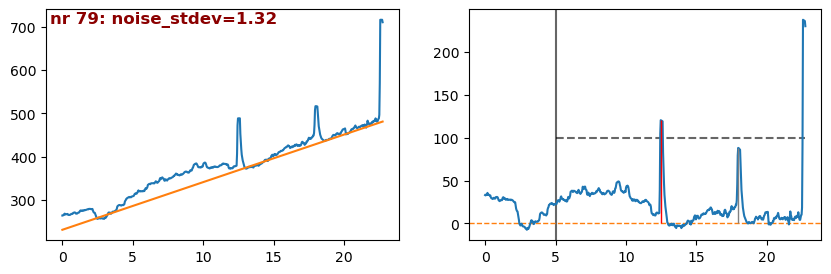

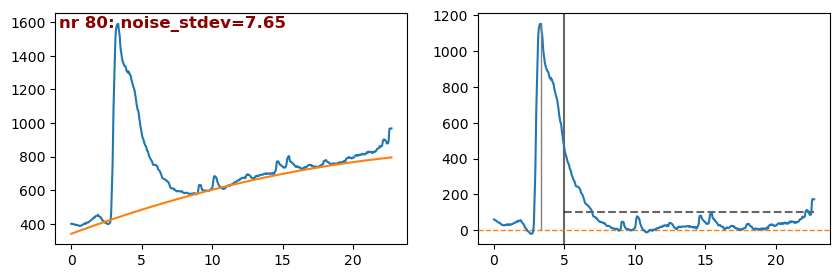

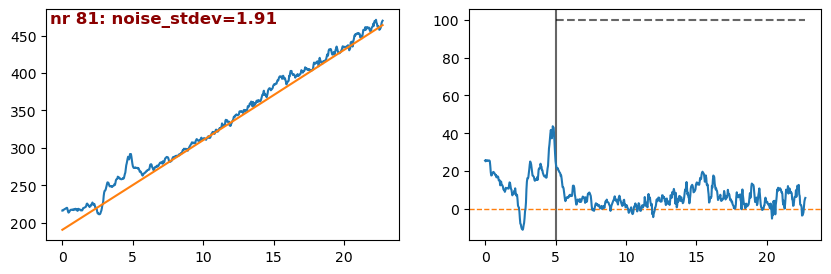

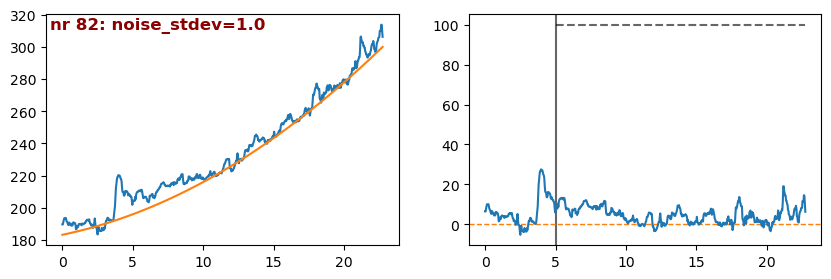

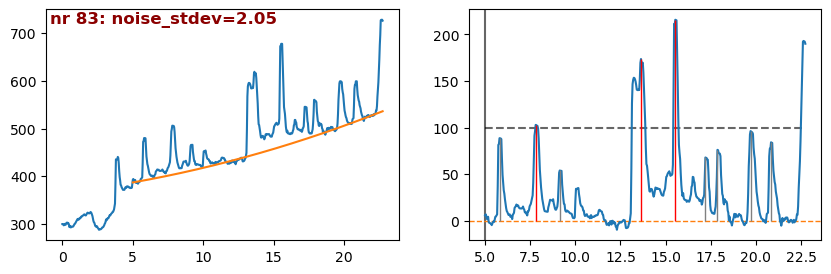

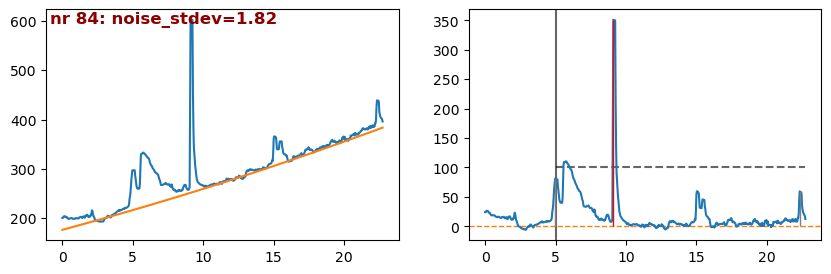

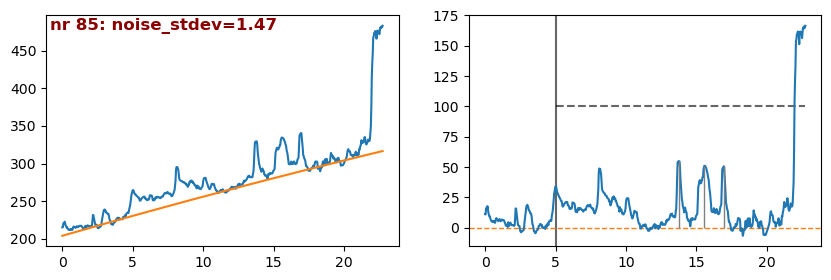

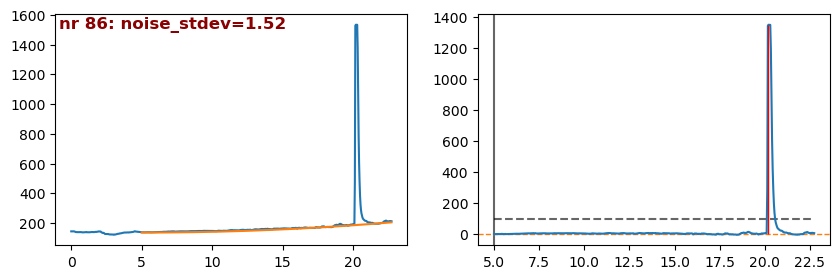

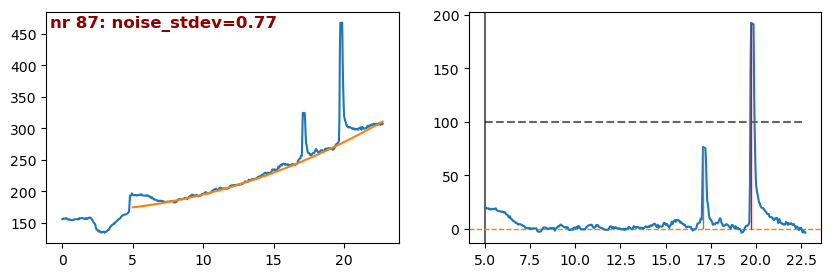

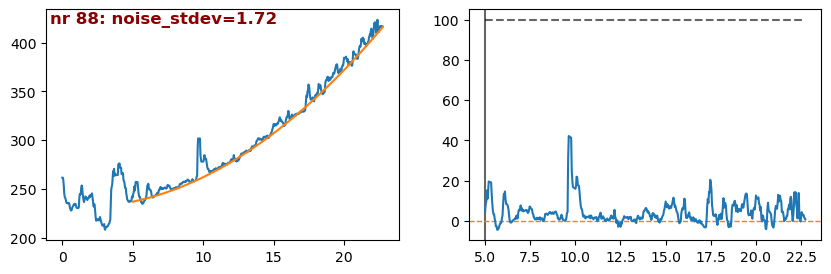

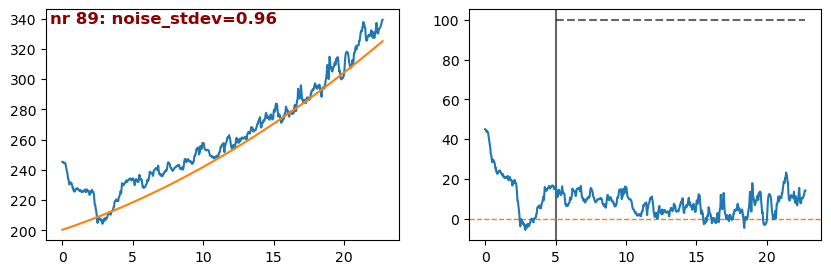

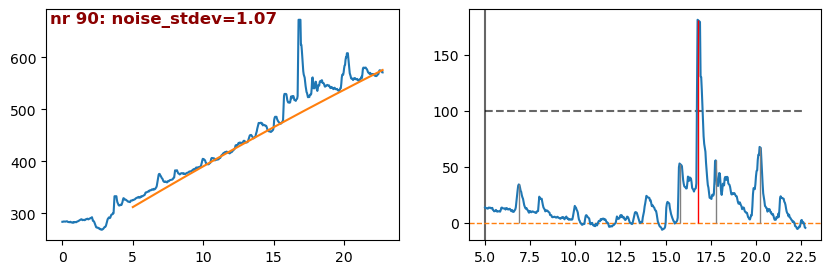

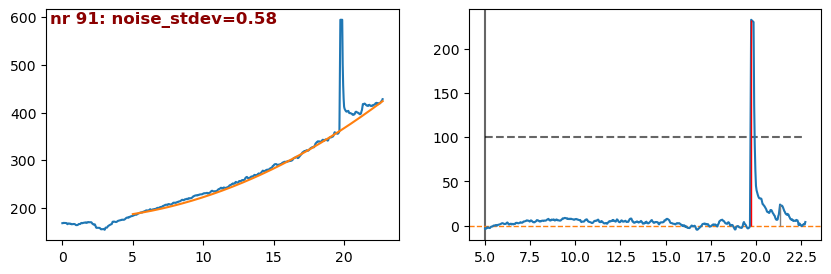

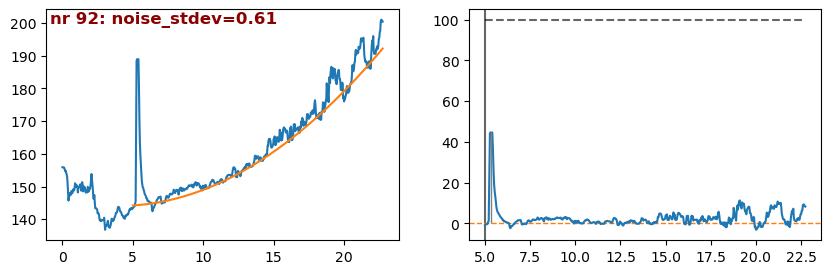

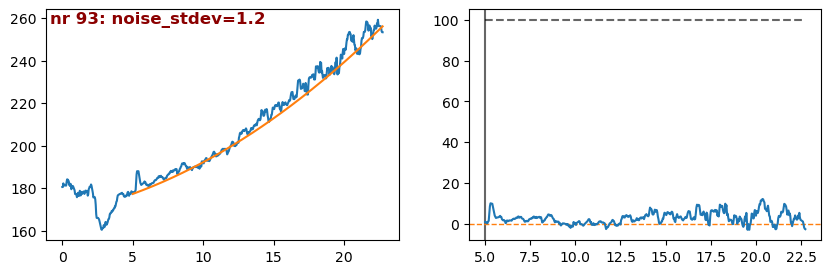

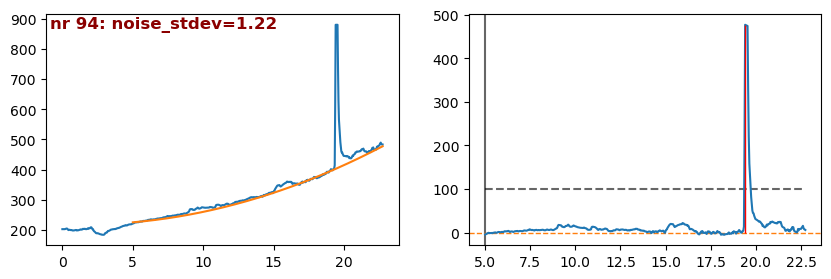

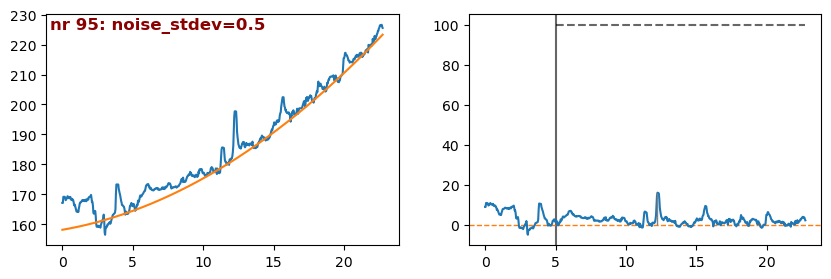

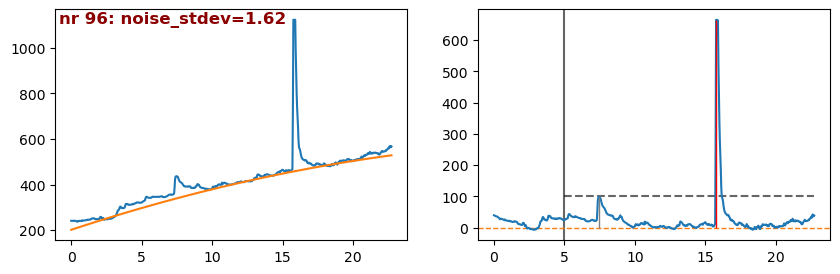

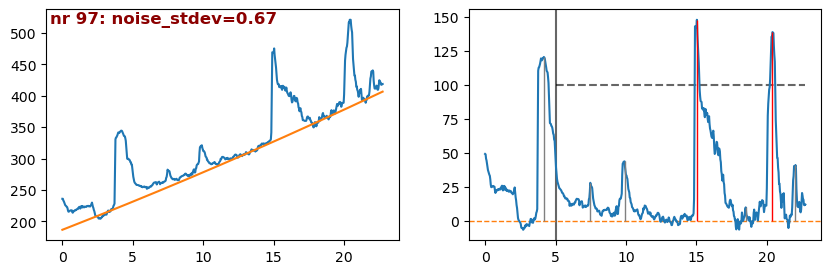

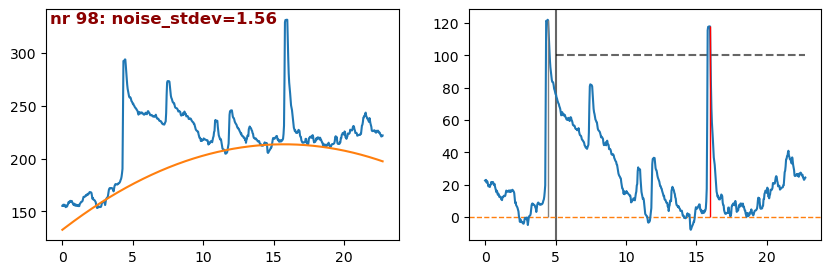

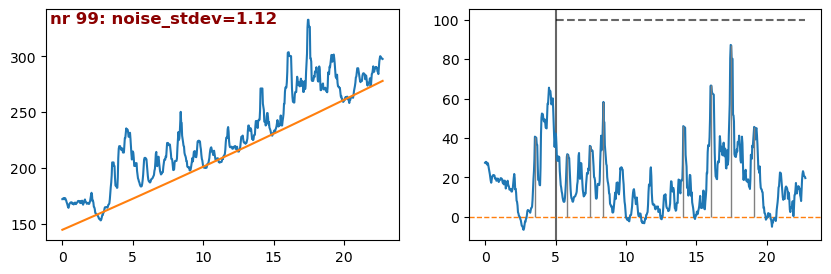

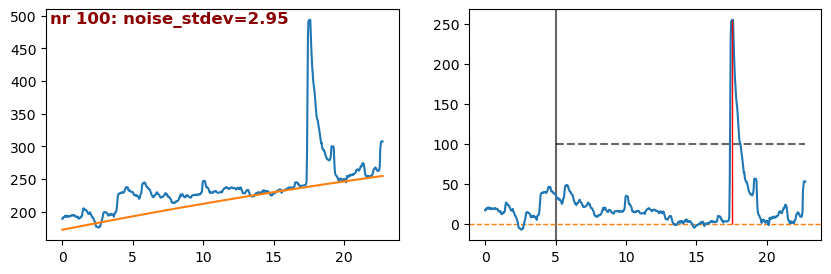

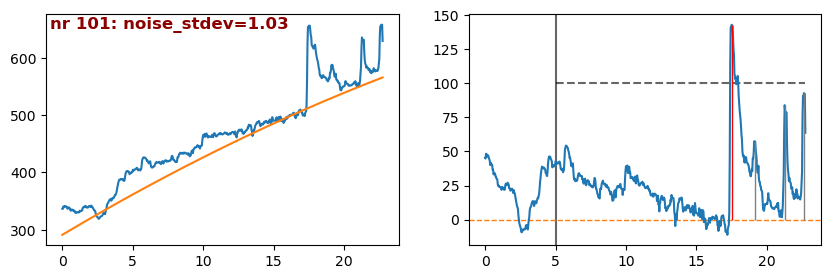

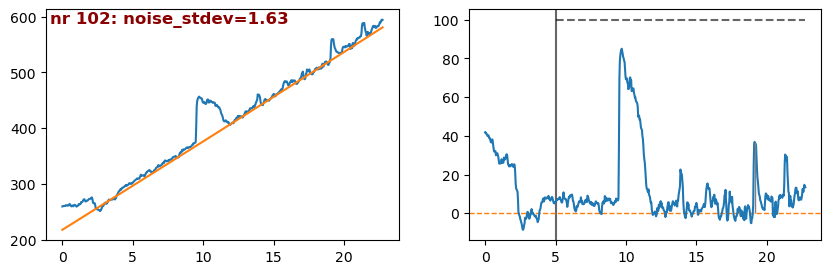

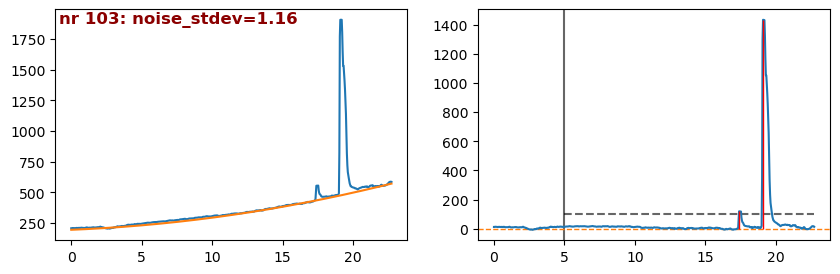

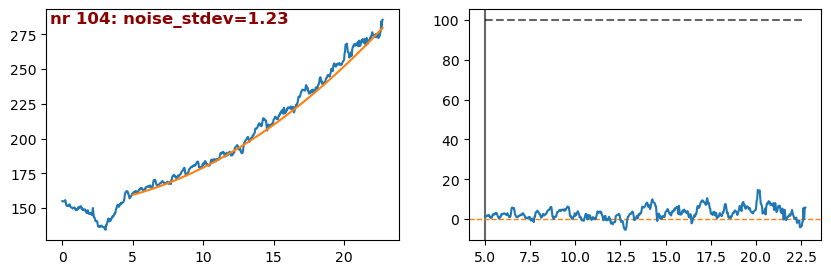

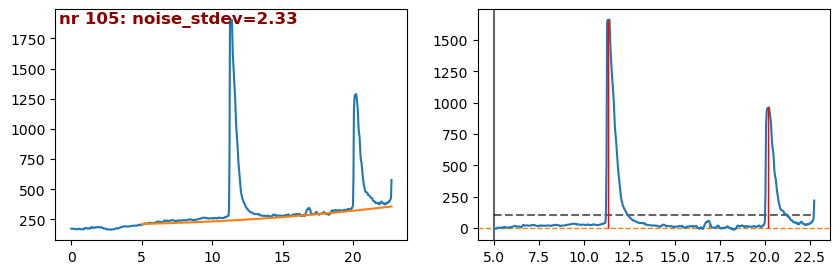

In [25]:
earliest_peak_idx: int = len(df_data[df_data['time(m)'] < 5.0])
baseline_fitter = ModPolyCustomBaseLineFitter(
    poly_order=2,
    optional_segment_length=earliest_peak_idx
)
peak_detector = NoiseSDScipyPeakDetector(
    prominence_in_stdev=20,
    wlen=30,
    distance=15,
    min_peak_amplitude=(100.0, 100.0),
    earliest_peak_idx=earliest_peak_idx,
)

plot_processing(
    df_input=df_data,
    time_colname='time(m)',
    baseline_fitter=baseline_fitter,
    peak_detector=peak_detector,
    s_stdev=stdev_base
)

# earliest_peak_idx: int = len(df_data[df_data['time(m)'] < 26.0])
# baseline_fitter = FirstNBaseLineFitter(
#     agg_func=np.mean,
#     first_n=FIRST_N
# )
# peak_detector = SingleMaxPeakDetector(
#     min_peak_amplitude=(100.0, 100.0),
#     earliest_peak_idx=earliest_peak_idx,
# )

# plot_processing(
#     df_input=df_data,
#     time_colname='time(m)',
#     baseline_fitter=baseline_fitter,
#     peak_detector=peak_detector,
# )